In [1]:
%cd /scratch/ejk5818/FLORIDA

/scratch/ejk5818/FLORIDA


In [2]:
from plot_utils import *

# mal pcnt experiment

In [3]:
results_dict = get_mal_pcnt_exp_results()

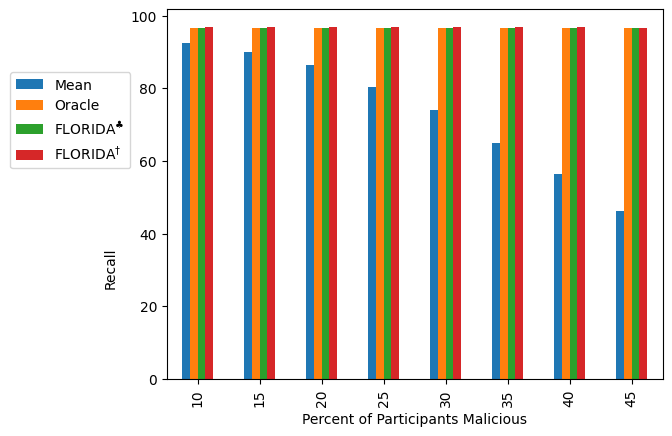

In [14]:
mal_pcnt_df = results_dict['mal_pcnt_df']
mal_pcnt_df = mal_pcnt_df.rename(defense_name_dict, axis=1)
mal_pcnt_df.index = mal_pcnt_df.index * 100
mal_pcnt_df.index.name = 'Percent of Participants Malicious'
mal_pcnt_df.index = mal_pcnt_df.index.astype(int)
ax = mal_pcnt_df.plot.bar()
ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ylabel = ax.set_ylabel('Recall')
ax.yaxis.set_label_coords(-0.1, 0.3)

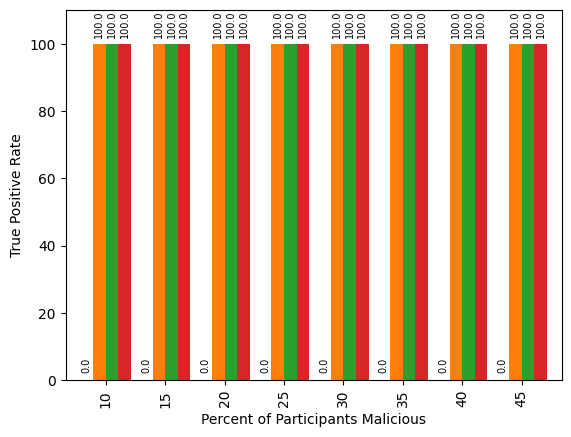

In [4]:
tpr_df = results_dict['tpr_df']
tpr_df = tpr_df.rename(defense_name_dict, axis=1)
tpr_df.index = tpr_df.index * 100
tpr_df.index.name = 'Percent of Participants Malicious'
tpr_df.index = tpr_df.index.astype(int)
ax = tpr_df.plot.bar(width=0.85)
# ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ax.legend().remove()
ylabel = ax.set_ylabel('True Positive Rate')
# ax.yaxis.set_label_coords(-0.1, 0.3)
ax.set_ylim(0, 110)
for p in ax.patches:
    value = round(p.get_height(), 2)
    value = float(value)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                ha='center', va='bottom', rotation=90, fontsize=7)

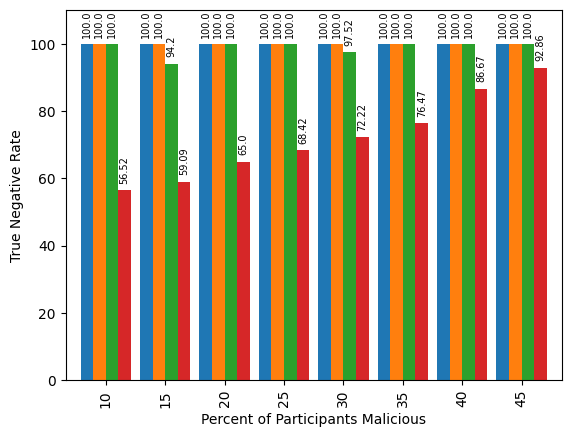

In [5]:
tnr_df = results_dict['tnr_df']
tnr_df = tnr_df.rename(defense_name_dict, axis=1)
tnr_df.index = tnr_df.index * 100
tnr_df.index.name = 'Percent of Participants Malicious'
tnr_df.index = tnr_df.index.astype(int)
ax = tnr_df.plot.bar(width=0.85)
# ax.legend(loc='center left', bbox_to_anchor=(-0.33, 0.7))
ax.legend().remove()
ylabel = ax.set_ylabel('True Negative Rate')
# ax.yaxis.set_label_coords(-0.1, 0.3)
ax.set_ylim(0, 110)
for p in ax.patches:
    value = round(p.get_height(), 2)
    value = float(value)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 2),
                ha='center', va='bottom', rotation=90, fontsize=7)

# non-IID experiment

In [112]:
# noniid_results, epoch_reports = get_noniid_exp_results()

epoch_reports = get_epoch_reports_json('saved_models/noniid_oce_100')

In [146]:
[count_of_class_for_validator['75'][str(i)] for i in range(10)]

[3, 2, 2, 3, 2, 2, 1, 30, 4, 5]

In [142]:
val_array_by_oce_group = { i: [] for i in range(10)}

all_validator_evaluations = epoch_reports['36']['validation_container']['all_validator_evaluations']

count_of_class_for_validator = epoch_reports['36']['validation_container']['count_of_class_for_validator']

for val in all_validator_evaluations:
    val_array_by_oce_group[int(val)//10].append(np.array(all_validator_evaluations[val]))

In [115]:
# project all_validator_evaluations to 2D using PCA
from sklearn.decomposition import PCA

# load data
pca = PCA(n_components=2)
# replace nan values with 0
all_validator_evaluations_vec = list(all_validator_evaluations.values())
all_validator_evaluations_vec = np.array(all_validator_evaluations_vec)
all_validator_evaluations_vec[np.isnan(all_validator_evaluations_vec)] = 0
pca.fit(all_validator_evaluations_vec)

projected_all_validator_evaluations = pca.transform(all_validator_evaluations_vec)



In [158]:
all_validator_evaluations_vec_compressed = all_validator_evaluations_vec.reshape(all_validator_evaluations_vec.shape[0], -1, 10)

weights = [[count_of_class_for_validator[j][str(i)] for i in range(10)] for j in all_validator_evaluations.keys()]
weights = [np.array(i)/np.sum(i) for i in weights]
weights = np.array(weights)

all_validator_evaluations_vec_compressed_weighted = [np.dot(all_validator_evaluations_vec_compressed[i], weights[i]) for i in range(len(all_validator_evaluations_vec_compressed))]
all_validator_evaluations_vec_compressed_weighted = np.array(all_validator_evaluations_vec_compressed_weighted)

pca_compressed = PCA(n_components=2)
pca_compressed.fit(all_validator_evaluations_vec_compressed_weighted)
all_validator_evaluations_vec_compressed_pca = pca_compressed.transform(all_validator_evaluations_vec_compressed_weighted)

In [116]:
group_numbers = list(all_validator_evaluations.keys())
group_numbers = [int(x)//10 for x in group_numbers]

marker_dict = {0: 'o', 1: 'x', 2: 's', 3: 'v', 4: 'D', 5: 'P', 6: 'p', 7: 'X', 8: 'd', 9: 'h'}
markers = [marker_dict[x] for x in group_numbers]

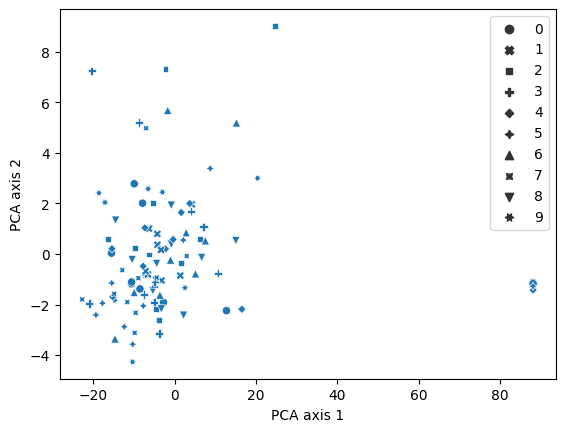

In [162]:
sns.scatterplot(x=projected_all_validator_evaluations[:, 0], y=projected_all_validator_evaluations[:, 1], style=group_numbers)
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')
plt.savefig('../FLORIDA_figures_sp/noniid_actual_pca.pdf')

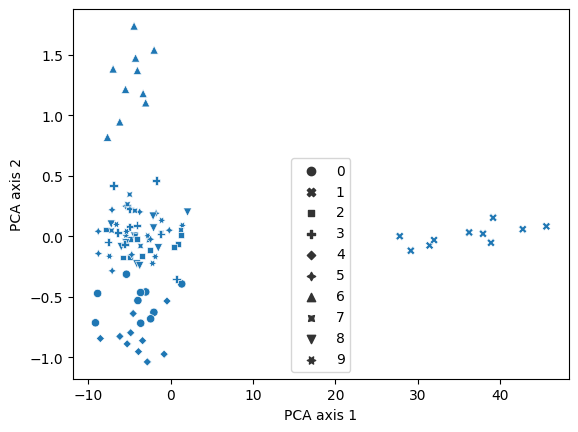

In [163]:
sns.scatterplot(x=all_validator_evaluations_vec_compressed_pca[:, 0], y=all_validator_evaluations_vec_compressed_pca[:, 1], style=group_numbers)
plt.xlabel('PCA axis 1')
plt.ylabel('PCA axis 2')
plt.savefig('../FLORIDA_figures_sp/noniid_alternate_pca.pdf')

In [139]:
def calc_distance(x, y):
    z = np.zeros(len(x))
    # x and y have same length
    # for any index i, if x[i] or y[i] is not a number, z[i] = 0
    # otherwise, z[i] = x[i] - y[i]
    for i in range(len(x)):
        if np.isnan(x[i]) or np.isnan(y[i]):
            z[i] = 0
        else:
            z[i] = x[i] - y[i]
    # return the norm of z calculated disregarding the entries that are 0
    if len(z[z != 0]) != 0:
        return np.linalg.norm(z[z != 0])/len(z[z != 0])
    else:
        return 0
    
def calc_distance_compressed(x, y):
    z = np.zeros(len(x))
    # x and y have same length
    # for any index i, if x[i] or y[i] is not a number, z[i] = 0
    # otherwise, z[i] = x[i] - y[i]
    for i in range(len(x)):
        if np.isnan(x[i]) or np.isnan(y[i]):
            z[i] = 0
        else:
            z[i] = x[i] - y[i]
    # return the norm of z calculated disregarding the entries that are 0
    if len(z[z != 0]) != 0:
        return np.linalg.norm(z[z != 0])/len(z[z != 0])
    else:
        return 0

/tmp/ipykernel_267699/502343691.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(intra_group_distances, shade=True, color="r", label="Intra-group distances")
/tmp/ipykernel_267699/502343691.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(inter_group_distances, shade=True, color="b", label="Inter-group distances")


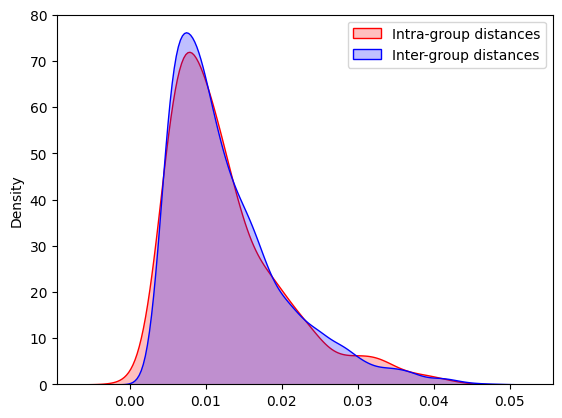

In [140]:
intra_group_distances = []

for i in range(10):
    intra_group_distances.extend([calc_distance(val_array_by_oce_group[i][j], val_array_by_oce_group[i][k]) for j in range(len(val_array_by_oce_group[i])) for k in range(j+1, len(val_array_by_oce_group[i])) if j != k])

inter_group_distances = []

for i in range(10):
    for j in range(i+1, 10):
        inter_group_distances.extend([calc_distance(val_array_by_oce_group[i][k], val_array_by_oce_group[j][l]) for k in range(len(val_array_by_oce_group[i])) for l in range(len(val_array_by_oce_group[j]))])

sns.kdeplot(intra_group_distances, shade=True, color="r", label="Intra-group distances")
sns.kdeplot(inter_group_distances, shade=True, color="b", label="Inter-group distances")
plt.legend()

In [126]:
np.mean(inter_group_distances)

0.012807098653823868

In [131]:
np.mean(intra_group_distances)

0.012584380658679886

# non-IID performance

In [ ]:
noniid_results, epoch_reports = get_noniid_exp_results()

<Axes: >

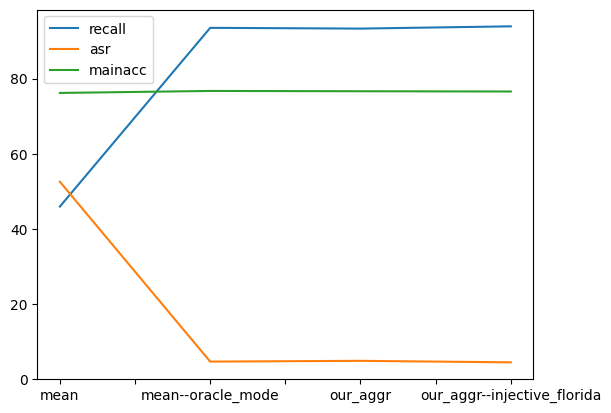

In [6]:
noniid_one_class_expert_df = pd.DataFrame(noniid_results['one_class_expert']).T
noniid_one_class_expert_df.plot()

<Axes: >

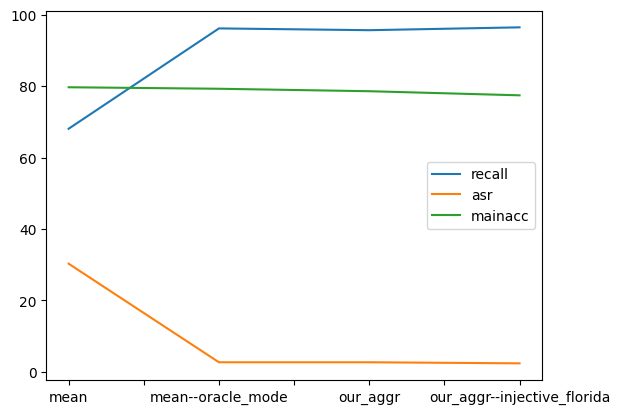

In [7]:
noniid_sampling_dirichlet_df = pd.DataFrame(noniid_results['sampling_dirichlet']).T
noniid_sampling_dirichlet_df.plot()

# mal val type experiment

In [3]:
final_result, avg_tpr, avg_tnr = get_mal_val_type_results()

In [7]:
cluster_final_result = final_result['our_aggr']
cluster_final_result_df = pd.DataFrame(cluster_final_result)
print(cluster_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 79.300000 & 79.100000 & 79.300000 \\
dba & 1.733333 & 2.466667 & 1.722222 \\
\bottomrule
\end{tabular}



In [8]:
bijective_final_result = final_result['our_aggr--injective_florida']
bijective_final_result_df = pd.DataFrame(bijective_final_result)
print(bijective_final_result_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 83.600000 & 83.400000 & 82.000000 \\
dba & 1.688889 & 1.866667 & 1.477778 \\
\bottomrule
\end{tabular}



In [9]:
cluster_tpr = avg_tpr['our_aggr']
cluster_tpr_df = pd.DataFrame(cluster_tpr)
print(cluster_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [10]:
bijective_tpr = avg_tpr['our_aggr--injective_florida']
bijective_tpr_df = pd.DataFrame(bijective_tpr)
print(bijective_tpr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.866667 & 0.866667 & 0.866667 \\
dba & 0.866667 & 0.866667 & 0.866667 \\
\bottomrule
\end{tabular}



In [11]:
cluster_tnr = avg_tnr['our_aggr']
cluster_tnr_df = pd.DataFrame(cluster_tnr)
print(cluster_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 0.910000 & 0.907500 & 0.907500 \\
dba & 1.000000 & 0.900000 & 1.000000 \\
\bottomrule
\end{tabular}



In [12]:
bijective_tnr = avg_tnr['our_aggr--injective_florida']
bijective_tnr_df = pd.DataFrame(bijective_tnr)
print(bijective_tnr_df.to_latex())

\begin{tabular}{lrrr}
\toprule
 & None & naive & adaptive \\
\midrule
targeted_label_flip & 1.000000 & 1.000000 & 1.000000 \\
dba & 1.000000 & 1.000000 & 1.000000 \\
\bottomrule
\end{tabular}



# 100 model, lipc pca, contrib adj

In [223]:
import torch
filepath = 'saved_models/ablation_same_adv_contrib_100_model_targeted_label_flip_cifar_sampling_dirichlet'
epoch_report = get_epoch_reports_json(filepath)
# eval_tensor = torch.load(filepath + '/eval_tensor.pt')
eval_tensor = torch.load('naive_eval_tensor.pt')

In [229]:
val_tensor = torch.load('val_tensor.pt')

In [232]:
val_array = val_tensor.numpy()

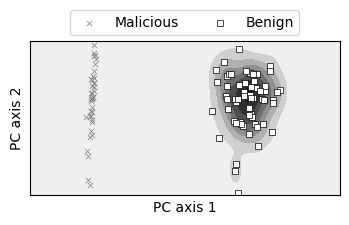

In [277]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming you have 2D points: x and y

x = val_array[:, 0]
y = val_array[:, 1]

# Create a 2D grid of points for plotting
# x_grid, y_grid = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
x_grid, y_grid = np.mgrid[-45:45:100j, -30:20:100j]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Estimate the kernel density
kernel = gaussian_kde(np.vstack([x[40:], y[40:]]))
density = kernel(positions).reshape(x_grid.shape)

cmap = plt.cm.gray.reversed()
# Plot the density contour and shade the area
plt.contourf(x_grid, y_grid, density, cmap=cmap)

# Plot the points
# plt.scatter(x, y, color='red', label='Points')
plt.scatter(x[:40], y[:40], color='gray', label='Malicious', marker='x', s=15, linewidths=0.5)
# use rectangle marker for benign points
marker='s'
plt.scatter(x[40:], y[40:], color='white', label='Benign', marker='s', edgecolors='black', s=15, linewidths=0.5)

# make axis equal
plt.axis('equal')
plt.xlim(-45, 45)
plt.ylim(-25, 15)

plt.xticks([])
plt.yticks([])

# Customize the plot if needed
# plt.title('Distribution of Points')
plt.xlabel('PC axis 1')
plt.ylabel('PC axis 2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=False, ncol=2)

# set plot size
plt.gcf().set_size_inches(4, 2)

# plt.show()
plt.savefig('../FLORIDA_figures/validation_result_pca_naive.pdf', bbox_inches='tight')


# 100 model adv contrib vs lipc

In [269]:
filepath='saved_models/ablation_same_adv_contrib_100_model_targeted_label_flip_cifar_sampling_dirichlet'
epoch_report = get_epoch_reports_json(filepath)

In [268]:
adv_contribs = []
weight_vecs_by_cluster = epoch_report['201']['weight_vecs_by_cluster']
for i in range(100):
    adv_contrib = weight_vecs_by_cluster[str(i)][:40]
    adv_contribs.append(adv_contrib)

In [270]:
import pickle
with open(f'{filepath}/validation_container_201.pkl', 'rb') as f:
    validation_container = pickle.load(f)

In [272]:
validation_container.keys()

dict_keys(['evaluations_of_clusters', 'count_of_class_for_validator', 'names', 'num_of_classes', 'num_of_clusters', 'all_validator_evaluations', 'epoch', 'params', 'cluster_maliciousness', 'benign_namelist', 'adversarial_namelist'])

In [273]:
lipc_scores = [-4.7487907, -2.769952, -5.454612, -5.1319194, -4.866832, -3.1563282, -2.8223853, -3.1325817, -4.522672, -3.8454134, -4.7845607, -3.0256062, -4.7793508, -4.8890157, -1.6697757, -3.1792095, -2.7945554, -3.016625, -4.9161625, -3.9265835, -5.9973016, -6.5325446, -4.4186964, -5.6589293, -3.8646832, -6.132945, -2.632554, -1.2281098, -1.7655197, -3.9949527, -3.7859776, -3.2990086, -3.6405792, -2.5016065, -5.009353, -3.9795296, -4.561721, -6.7815022, -3.4149902, -5.3214645, -2.0932765, -1.4055339, -2.037958, -1.3613176, -3.177412, -1.651884, -0.6936665, -2.5729785, -2.2385807, -1.6926868, -1.9435134, -2.3079793, -3.0758686, -2.2712827, -2.7811048, -2.6739113, -1.1271847, -2.2178867, -3.2088223, -1.474854, -2.92735, -1.3798997, -1.6585093, -1.4801625, -1.2921611, -1.9035263, -1.8385819, -0.7459074, -2.5916064, -1.42558, -2.8953578, -1.1255351, -1.6537284, -2.7899458, -3.30373, -3.049946, -2.4289525, -2.6561947, -1.1230806, -1.5017383, -1.72904, -1.8606869, -1.5149556, -1.7875767, -1.5895802, -1.0446929, -1.8040705, -1.0906372, -1.5544206, -3.4815612, -0.8816895, -3.0276773, -1.5094467, -2.741807, -2.014229, -1.4644346, -1.4729997, -0.93996185, -1.7958237, -2.0561512]

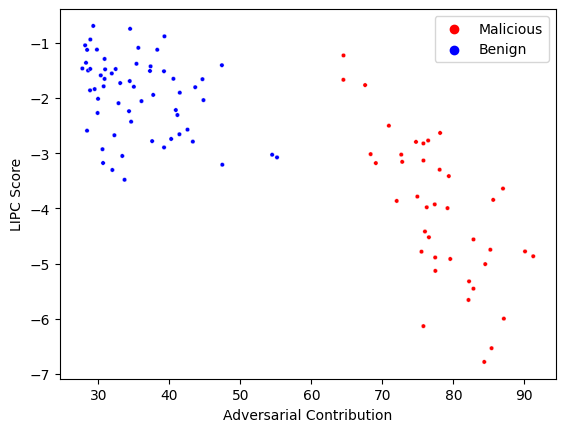

In [175]:
# ax = plt.scatter(adv_contribs, lipc_scores, color=['r']*40 + ['b']*60, s=0.5)
palette = {'Malicious': 'red', 'Benign': 'blue'}
ax = sns.scatterplot(x=adv_contribs, y=lipc_scores, hue=['Malicious']*40 + ['Benign']*60, palette=palette, s=10, markers=['x', 'o'])
ax.set_xlabel('Adversarial Contribution')
ax.set_ylabel('LIPC Score')
plt.savefig(f'../FLORIDA_figures/adv_contrib_vs_score.pdf', bbox_inches='tight')
# ax.legend(['Malicious', 'Benign'])

# contrib adjustment visualization

In [189]:
contrib_adj = [0, 0.25, 0.5, 0.75]
attack_methods= ['targeted_label_flip']
file_paths = {attack_method: {adj: f'saved_results/contrib_adjustment/contrib_adj_{adj}_cifar_{attack_method}' for adj in contrib_adj} for attack_method in attack_methods}
epoch_reports = {attack_method: {adj: get_epoch_reports_json(file_path) for adj, file_path in file_paths[attack_method].items()} for attack_method in attack_methods}

In [190]:
benign_contribs, adv_contribs = [[], []], [[], []]
epoch_report = epoch_reports['targeted_label_flip'][0.75]['201']
for i in range(10):
    weight_vec = epoch_report['weight_vecs_by_cluster'][str(i)]
    weight_vec = [100 * w for w in weight_vec]
    adv_contribs[0].append(np.sum(weight_vec[10:]))
    benign_contribs[0].append(np.sum(weight_vec[:10]))
for i in range(10, 25):
    weight_vec = epoch_report['weight_vecs_by_cluster'][str(i)]
    weight_vec = [100 * w for w in weight_vec]
    adv_contribs[1].append(np.sum(weight_vec[10:]))
    benign_contribs[1].append(np.sum(weight_vec[:10]))

In [191]:
import torch
eval_tensors = {attack_methods[0]: {adj: torch.load(f'saved_results/contrib_adjustment/contrib_adj_{adj}_cifar_{attack_methods[0]}/eval_tensor.pt') for adj in contrib_adj}}

In [192]:
# epoch_reports['targeted_label_flip'][0.75]['201']['argsort_result']
benign_model_id = 16
malicious_model_id = 7

In [193]:
benign_eval_array = eval_tensors['targeted_label_flip'][0.75][:,benign_model_id,:].detach().cpu().numpy()
malicious_eval_array = eval_tensors['targeted_label_flip'][0.75][:,malicious_model_id,:].detach().cpu().numpy()

In [194]:
eval_array = eval_tensors['targeted_label_flip'][0.75].detach().cpu().numpy()

In [195]:
benign_lipc_array = np.mean(eval_array[:,10:,:], axis=0)
malicious_lipc_array = np.mean(eval_array[:,:10,:], axis=0)

In [196]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [197]:
pca.fit(eval_array.reshape(-1, 10))

PCA(n_components=2)

In [198]:
benign_pca_result = pca.transform(benign_eval_array.reshape(-1, 10))
malicious_pca_result = pca.transform(malicious_eval_array.reshape(-1, 10))

In [199]:
all_pca_result = [pca.transform(eval_array[:,i,:]) for i in range(eval_array.shape[0])]

In [200]:
def get_circle(pca_result, benign=True):
    num_points = int(len(pca_result) / 2)
    mean_pca_result = np.mean(pca_result[:num_points], axis=0)
    pca_dists = np.linalg.norm(pca_result - mean_pca_result, axis=1)
    sorted_pca_result = pca_result[np.argsort(pca_dists)]

    circle_radius = np.linalg.norm(sorted_pca_result[num_points] - mean_pca_result)
    color = 'b' if benign else 'r'
    circle = plt.Circle(mean_pca_result, circle_radius, color=color, fill=False)
    return circle

In [201]:
all_circles = [get_circle(pca_result, benign=(i>=10)) for i, pca_result in enumerate(all_pca_result)]

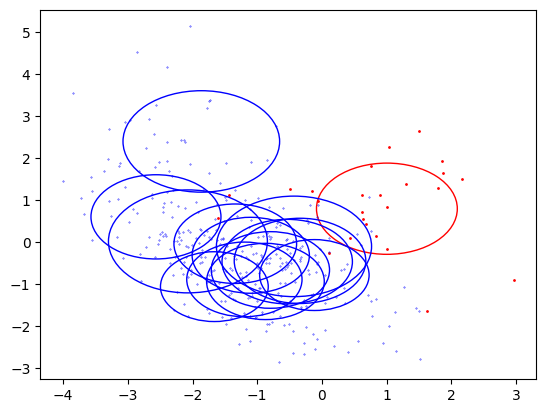

In [202]:
for i, pca_result in enumerate(all_pca_result):
    if i in epoch_reports['targeted_label_flip'][0.75]['201']['argsort_result'][12:] or i==malicious_model_id:
        plt.scatter(pca_result[:,0], pca_result[:,1], c='r' if i < 10 else 'b', s=1 if i < 10 else 0.1)

        plt.gca().add_patch(all_circles[i])

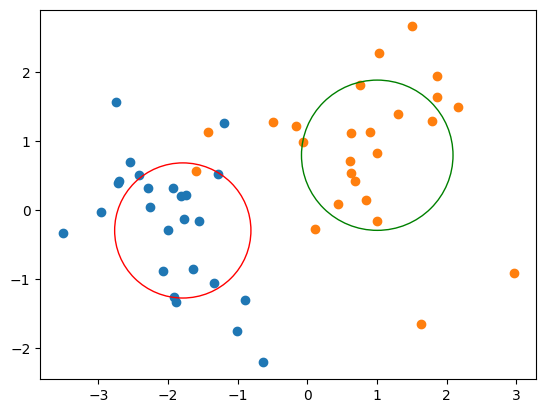

In [203]:
plt.scatter(benign_pca_result[:,0], benign_pca_result[:,1], label='benign')
plt.scatter(malicious_pca_result[:,0], malicious_pca_result[:,1], label='malicious')

benign_circle = plt.Circle(mean_benign_pca_result, benign_circle_radius, color='r', fill=False)

plt.gca().add_patch(benign_circle)

malicious_circle = plt.Circle(mean_malicious_pca_result, malicious_circle_radius, color='g', fill=False)

plt.gca().add_patch(malicious_circle)


In [52]:
# PCA on both benign and malicious eval tensors and plot
mean = torch.mean(torch.stack([benign_eval_tensor, malicious_eval_tensor]), dim=0)
benign_eval_tensor_norm = benign_eval_tensor - mean
malicious_eval_tensor_norm = malicious_eval_tensor - mean
_, _, V = torch.svd(torch.stack([benign_eval_tensor_norm, malicious_eval_tensor_norm], dim=0))

# contrib adjustment experiment

In [3]:
final_perf_tpr_tnr = get_contrib_adj_results()

In [4]:
plot_df = lambda dict_, key: pd.DataFrame.from_dict(dict_[key], orient='index').T

<Axes: >

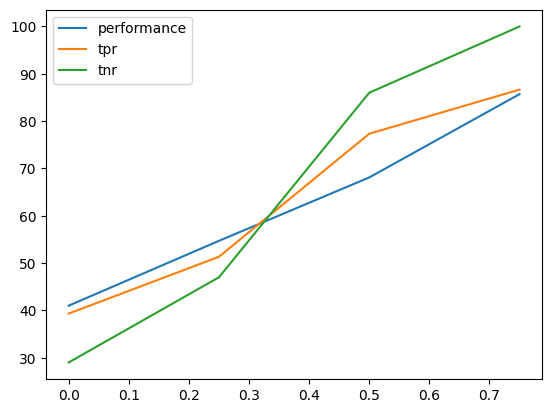

In [5]:
plot_df(final_perf_tpr_tnr, 'targeted_label_flip').plot()

<Axes: >

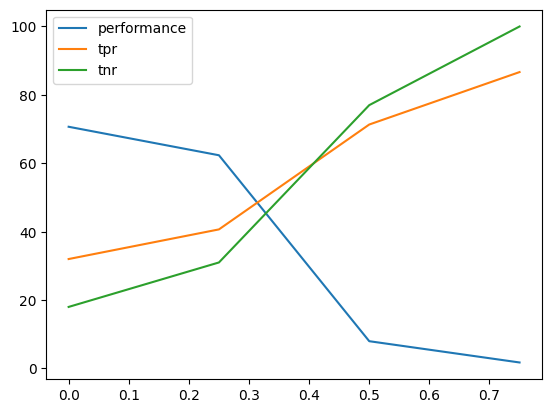

In [6]:
plot_df(final_perf_tpr_tnr, 'dba').plot()

# Adversarial contribution in ensemble model vs LIPC score

In [14]:
adv_contrib_vs_score_df_orig = get_adv_contrib_vs_score()

/tmp/ipykernel_2555280/44872535.py:10: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(handles=ax.legend_.legendHandles[4:], labels=distribution_dict.values(), loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)


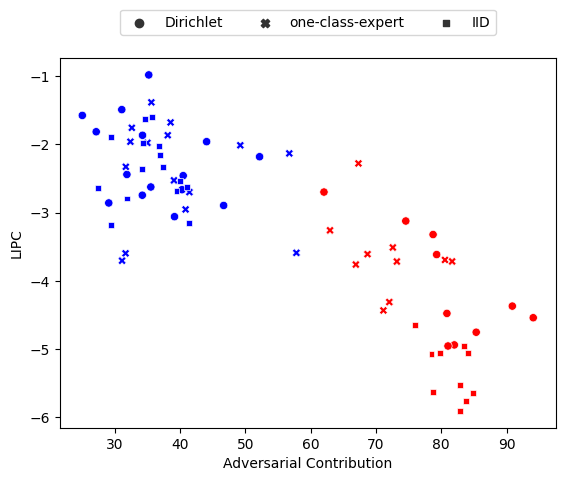

In [35]:
adv_contrib_vs_score_df = adv_contrib_vs_score_df_orig.copy()
adv_contrib_vs_score_df = adv_contrib_vs_score_df.rename({'adv_contrib': 'Adversarial Contribution', 'score': 'LIPC', 'noniid': 'Distribution'}, axis=1)
adv_dict = {True: 'Malicious', False: 'Benign'}
custom_palette = {'Malicious': 'red', 'Benign': 'blue'}
distribution_dict = {0: 'Dirichlet', 1: 'one-class-expert', 2: 'IID'}
adv_contrib_vs_score_df['Adversarial Contribution'] = adv_contrib_vs_score_df['Adversarial Contribution'] * 100
adv_contrib_vs_score_df['is_adv'] = adv_contrib_vs_score_df['is_adv'].apply(lambda x: adv_dict[x])
adv_contrib_vs_score_df['Distribution'] = adv_contrib_vs_score_df['Distribution'].apply(lambda x: distribution_dict[x])
ax = sns.scatterplot(x='Adversarial Contribution', y='LIPC', style='Distribution', hue='is_adv', data=adv_contrib_vs_score_df, palette=custom_palette)
ax.legend(handles=ax.legend_.legendHandles[4:], labels=distribution_dict.values(), loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# ax.legend(handles=ax.legend_.legendHandles[1:3], labels=adv_dict.values(), loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=1)
plt.savefig('../FLORIDA_figures/adv_contrib_vs_score.pdf', bbox_inches='tight')

In [179]:
adv_contrib_vs_score_df

,adv_contrib,score,is_adv
0,0.853502,-4.755714,1.0
1,0.745627,-3.123651,1.0
2,0.820023,-4.941964,1.0
3,0.810291,-4.957726,1.0
4,0.908863,-4.372340,1.0
...,...,...,...
70,0.345362,-1.627898,0.0
71,0.400248,-2.538997,0.0
72,0.410384,-2.620564,0.0
73,0.367575,-2.028632,0.0


# Ablation Aggregate Ensemble

In [9]:
aggregate_ensemble_result_df = get_ablation_aggregate_ensemble_results()
aggregate_ensemble_result_df['mean_sneak_contribs'] = aggregate_ensemble_result_df['mean_sneak_contribs'] * 100

In [10]:
print(aggregate_ensemble_result_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
 & mean_sneak_contribs & avg_tpr & avg_tnr & final_result \\
\midrule
True & 8.60 & 99.00 & 86.00 & 51.00 \\
False & 0.00 & 100.00 & 86.67 & 0.43 \\
\bottomrule
\end{tabular}



# Ablation Clustering Comparison

In [309]:
cluster_results_df = get_cluster_comparison_results()

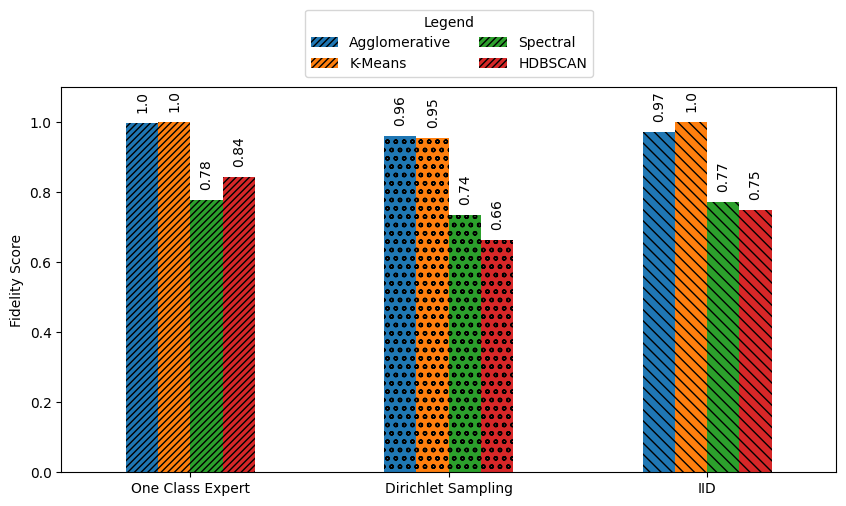

In [311]:
hatches=['/////', 'oo', '\\\\\\', '....']
ax = cluster_results_df.plot.bar(rot=0, hatch=hatches, figsize=(10, 5))
ax.set_ylabel('Fidelity Score')
ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.03),
                ha='center', va='bottom', rotation=90)
ax.set_ylim(0, 1.1)
plt.savefig('../FLORIDA_figures/cluster_comparison.pdf', bbox_inches='tight')


In [5]:
cluster_results_n_cluster_2_df = get_cluster_comparison_n_cluster_2_results()

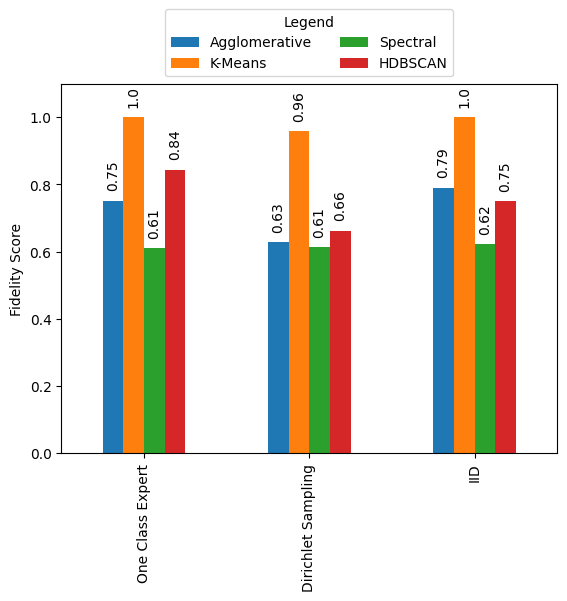

In [7]:
ax = cluster_results_n_cluster_2_df.plot.bar()
ax.set_ylabel('Fidelity Score')
ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.03),
                ha='center', va='bottom', rotation=90)
ax.set_ylim(0, 1.1)
plt.savefig('../FLORIDA_figures/cluster_comparison_n_cluster_2.pdf', bbox_inches='tight')

# Ablation Imputation Comparison

In [6]:
imputation_dfs = get_imputation_comparison_results()

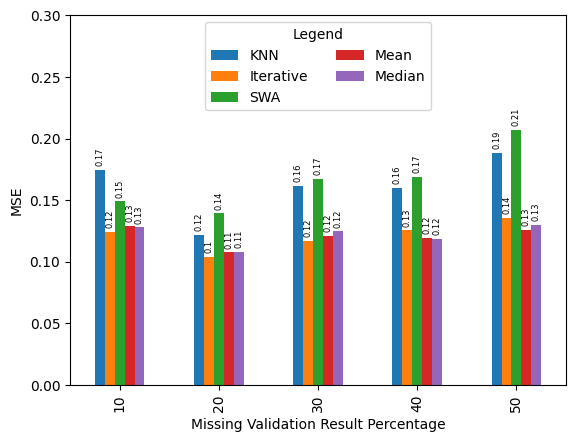

In [39]:
ax = imputation_dfs['False'].plot.bar()
ax.set_ylabel('MSE')
ax.legend(title='Legend', loc='upper center', ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 2)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.3)
ax.set_xlabel('Missing Validation Result Percentage')
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_iid.pdf', bbox_inches='tight')

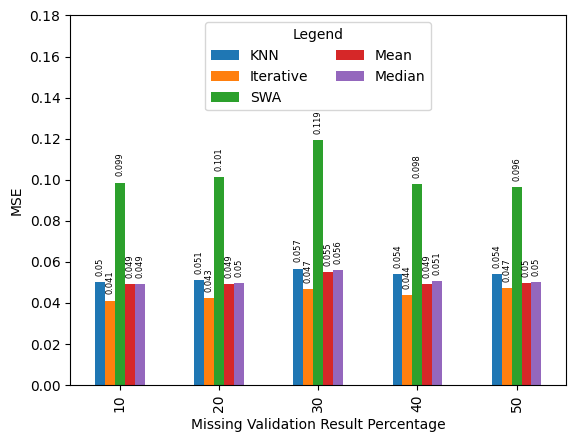

In [38]:
ax = imputation_dfs['one_class_expert'].plot.bar()
ax.set_ylabel('MSE')
# ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 3)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.18)
ax.legend(title='Legend', loc='upper center', ncol=2)
ax.set_xlabel('Missing Validation Result Percentage')
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_one_class_expert.pdf', bbox_inches='tight')

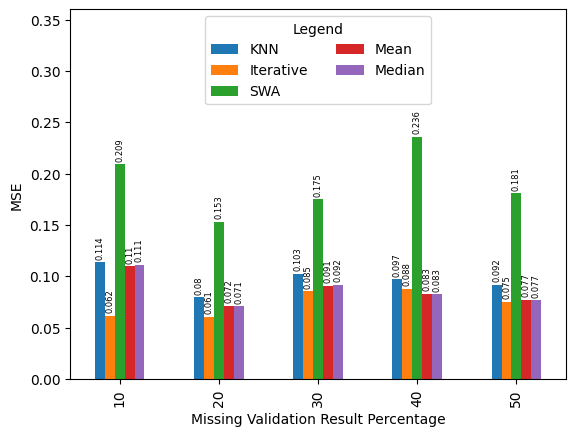

In [43]:
ax = imputation_dfs['sampling_dirichlet'].plot.bar()
ax.set_ylabel('MSE')
# ax.legend(title='Legend', loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=2)
for p in ax.patches:
    value = round(p.get_height(), 3)
    ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2, p.get_height() + 0.003),
                ha='center', va='bottom', rotation=90, fontsize=6)
ax.set_ylim(0, 0.36)
ax.set_xlabel('Missing Validation Result Percentage')
ax.legend(title='Legend', loc='upper center', ncol=2)
plt.savefig('../FLORIDA_figures/ablation_imputation_comparison_sampling_dirichlet.pdf', bbox_inches='tight')

# Ablation Number of Validators Comparison

In [7]:
num_of_validators_df = get_num_of_validators_results()

In [8]:
print(num_of_validators_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & BA & Avg TPR & Avg TNR \\
\midrule
10 & 3.61 & 97.50 & 81.67 \\
15 & 3.46 & 100.00 & 88.89 \\
20 & 2.64 & 100.00 & 83.33 \\
25 & 1.89 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Ablation Validation Metric

In [279]:
filepaths = {
    k: f'saved_results/ablation_validation_metric/validation_metric_{k}_cifar_None_targeted_label_flip' for k in ['accuracy', 'LIPC']
}
epoch_reports = {
    k: get_epoch_reports_json(filepath) for k, filepath in filepaths.items()
}

/tmp/ipykernel_2555280/3136013024.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_vals, fontsize=6)


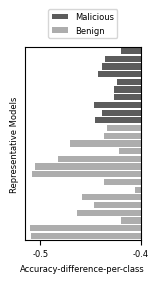

In [308]:
plot_data = [epoch_reports[i]['201']['lowest_score_for_each_cluster'] for i in epoch_reports.keys()]
# rotate the plot 90 degrees counter-clockwise
light_gray = sns.color_palette("Greys")[2]
dark_gray = sns.color_palette("Greys")[4]
ax = sns.barplot(x=plot_data[0], y=np.arange(len(plot_data[0])), palette=[dark_gray]*10+[light_gray]*15, orient='h')
ax.set_yticks([])
ax.set_ylabel('Representative Models', fontsize=6)
ax.set_xlabel('Accuracy-difference-per-class', fontsize=6)
# set font size of labels
xtick_vals = [round(i, 2) for i in ax.get_xticks()]
ax.set_xticklabels(xtick_vals, fontsize=6)
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=dark_gray), plt.Rectangle((0, 0), 1, 1, fc=light_gray)]
legend_labels = ['Malicious', 'Benign']

# Plot the legend with custom handles and labels
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=1, fontsize=6)
# set figure size
fig = plt.gcf()
fig.set_size_inches(1.5, 2.5)
plt.savefig('../FLORIDA_figures/ablation_validation_metric_accuracy.pdf', bbox_inches='tight')

/tmp/ipykernel_2555280/2072400987.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtick_vals, fontsize=6)


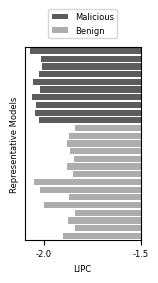

In [307]:
plot_data = [epoch_reports[i]['201']['lowest_score_for_each_cluster'] for i in epoch_reports.keys()]
# rotate the plot 90 degrees counter-clockwise
light_gray = sns.color_palette("Greys")[2]
dark_gray = sns.color_palette("Greys")[4]
ax = sns.barplot(x=plot_data[1], y=np.arange(len(plot_data[0])), palette=[dark_gray]*10+[light_gray]*15, orient='h')
ax.set_yticks([])
ax.set_ylabel('Representative Models', fontsize=6)
ax.set_xlabel('LIPC', fontsize=6)
# set font size of labels
xtick_vals = [round(i, 2) for i in ax.get_xticks()]
ax.set_xticklabels(xtick_vals, fontsize=6)
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=dark_gray), plt.Rectangle((0, 0), 1, 1, fc=light_gray)]
legend_labels = ['Malicious', 'Benign']

# Plot the legend with custom handles and labels
ax.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=1, fontsize=6)
# set figure size
fig = plt.gcf()
fig.set_size_inches(1.5, 2.5)
plt.savefig('../FLORIDA_figures/ablation_validation_metric_LIPC.pdf', bbox_inches='tight')

# Ablation Use Mean

In [5]:
result_dict_df = get_use_mean_results()

In [6]:
print(result_dict_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Recall & TPR & TNR \\
\midrule
True & 73.00 & 80.60 & 73.73 \\
False & 83.60 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Ablation No Detector

In [3]:
result_dict_df = get_no_detector_results()

In [4]:
print(result_dict_df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrr}
\toprule
 & Recall & TPR & TNR \\
\midrule
True & 15.70 & 10.00 & 26.67 \\
False & 83.40 & 100.00 & 86.67 \\
\bottomrule
\end{tabular}



# Adaptive Mal Val Type Loss Plot

In [204]:
import torch

In [205]:
cluster_losses = torch.load('cluster_losses.pt').detach().cpu().numpy()[:1000]
distance_losses = torch.load('distance_losses.pt').detach().cpu().numpy()[:1000]
mal_val_impacts = torch.load('mal_val_impacts.pt').detach().cpu().numpy()[:1000]

In [180]:
cluster_losses[:10]

array([9.86117 , 9.392563, 9.669287, 9.245258, 9.959369, 9.86117 ,
       9.780724, 9.959369, 9.105865, 9.648134], dtype=float32)

Text(0, 0.5, 'Distance Loss')

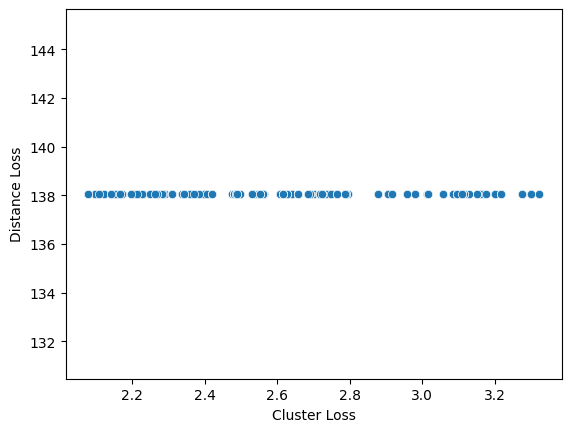

In [206]:
ax=sns.scatterplot(x=cluster_losses, y=distance_losses)
ax.set_xlabel('Cluster Loss')
ax.set_ylabel('Distance Loss')

<Axes: >

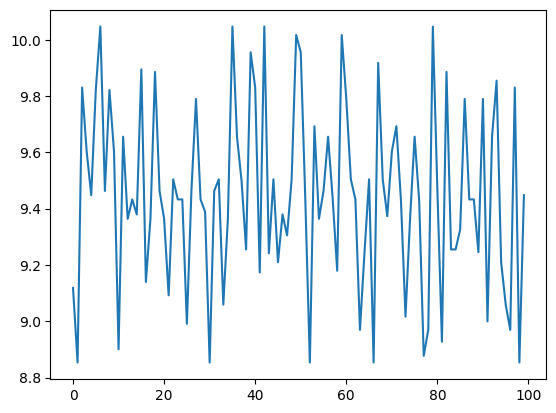

In [32]:
sns.lineplot(x=np.arange(len(losses[:100])), y=losses[:100])

In [19]:
running_mean_losses = np.convolve(losses, np.ones(10)/10, mode='valid')

In [33]:
min_till_now_losses = np.minimum.accumulate(losses)

<Axes: >

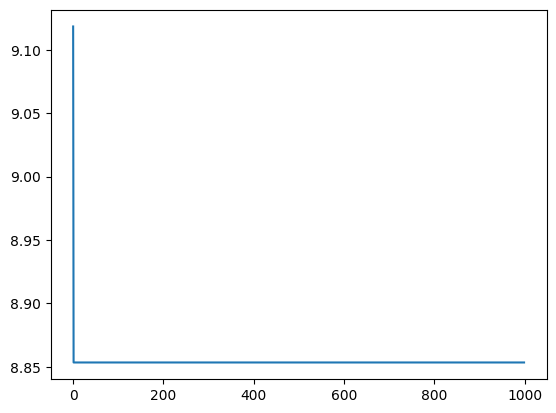

In [34]:
sns.lineplot(x=np.arange(len(min_till_now_losses)), y=min_till_now_losses)

# expected similarity

In [70]:
def get_similarity_report(epoch_report, dist_type='cosine'):
    try:
        num_of_adversary = 10
        if dist_type == 'cosine':
            cos_sim = np.array(epoch_report['all_cos_dists'])
        elif dist_type == 'euclidean':
            cos_sim = np.array(epoch_report['all_euclidean_dists'])
        masks = [np.zeros_like(cos_sim) for _ in range(3)]
        masks[0][:num_of_adversary, :num_of_adversary] = 1
        masks[1][num_of_adversary:, num_of_adversary:] = 1
        masks[2][:num_of_adversary, num_of_adversary:] = 1
        masks[2][num_of_adversary:, :num_of_adversary] = 1
        # make the diagonal 0
        for mask in masks:
            np.fill_diagonal(mask, 0)
        cos_sim = cos_sim.ravel()
        masks = [mask.ravel() for mask in masks]
        sims = [cos_sim[mask==1] for mask in masks]
        sims = [sim for sim in sims]
        return sims
    except:
        return np.nan

In [72]:
def get_all_similarity_reports(epoch_reports, epoch_range=None, dist_type='cosine'):
    if epoch_range is None:
        epoch_range = range(int(epoch_reports['starting_epoch']), int(epoch_reports['final_epoch'])+1)
    similarity_reports = [[] for _ in range(3)]
    for epoch in epoch_range:
        epoch_report = epoch_reports[str(epoch)]
        similarity_report = get_similarity_report(epoch_report, dist_type=dist_type)
        if similarity_report is not None:
            for i in range(3):
                similarity_reports[i].extend(similarity_report[i])
    return similarity_reports

In [113]:
filepaths = {
    k: f'saved_results/similarity_report/ablation_similarity_report_fmnist_targeted_label_flip_{k}' for k in ['iid', 'one_class_expert', 'sampling_dirichlet']
}
epoch_reports = {
    k: get_epoch_reports_json(filepaths[k]) for k in filepaths.keys()
}

In [115]:
sims = [get_all_similarity_reports(epoch_reports[k], dist_type='euclidean') for k in epoch_reports.keys()]

0.8528855443000793 3.9288437366485596
0.6995974779129028 3.1953349113464355
0.4894130527973175 5.391221523284912


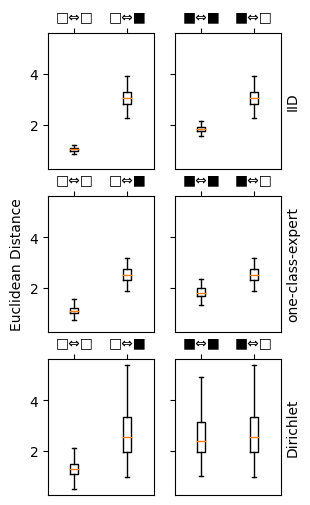

In [135]:
# create box plot of sims[0] and sims[2]
fig, ax = plt.subplots(figsize=(3, 6), nrows=3, ncols=2, sharey=True)
xlabels = ['IID', 'one-class-expert', 'Dirichlet']
for i in range(3):
    whiskers = []
    for j in range(2):
        sim = sims[i]
        if j==0:
            box = ax[i, j].boxplot([sim[1], sim[2]], showfliers=False)
        elif j==1:
            box = ax[i, j].boxplot([sim[0], sim[2]], showfliers=False)
        whiskers.extend([w.get_ydata()[1] for w in box['whiskers']])
        if j==1:
            ax[i, j].set_xticklabels(['\u25A0⇔\u25A0', '\u25A0⇔\u25A1'])
        else:
            ax[i, j].set_xticklabels(['\u25A1⇔\u25A1', '\u25A1⇔\u25A0'])
        ax[i, j].xaxis.tick_top()
        if i ==1 and j==0:
            ax[i, j].set_ylabel('Euclidean Distance')
        if j==1:
            ax[i, j].yaxis.set_label_position("right")
            
            ax[i, j].set_ylabel(f'{xlabels[i]}')
        # ax[i, j].set_xticklabels(['Malicious-Malicious', 'Malicious-Benign'], rotation=90)
        # ax[i, j].set_ylabel('Euclidean Distance')
        # ax[i, j].set_xlabel('IID')
    print(np.min(whiskers), np.max(whiskers))
    # ax[i, 0].set_ylim(np.min(whiskers), np.max(whiskers))
    # ax[i, 1].set_ylim(np.min(whiskers), np.max(whiskers))

plt.savefig('../FLORIDA_figures/ablation_similarity_report_1.pdf', bbox_inches='tight')

# ax.boxplot([sims[0], sims[2]])
# # ax.set_xticklabels(['Malicious-Malicious', 'Malicious-Benign'], rotation=90)
# ax.set_xticklabels(['\u25A0⇔\u25A0', '\u25A0⇔\u25A1'])
# ax.xaxis.tick_top()
# ax.set_ylabel('Euclidean Distance')
# ax.set_xlabel('IID')

In [53]:
epoch_report = epoch_reports['201']

In [ ]:
get_similarity_report(epoch_report, dist_type='cosine')

# ablation contribution report

In [149]:
filepaths = {
    k: f'saved_results/similarity_report/ablation_similarity_report_fmnist_targeted_label_flip_{k}' for k in ['iid', 'one_class_expert', 'sampling_dirichlet']
}
epoch_reports = {
    k: get_epoch_reports_json(filepaths[k]) for k in filepaths.keys()
}

In [150]:
epoch_report = epoch_reports['sampling_dirichlet']['36']

In [151]:
benign_contribs, adv_contribs = [[], []], [[], []]
for epoch in range(36, 51):
    epoch_report = epoch_reports['sampling_dirichlet'][str(epoch)]
    for i in range(10):
        weight_vec = epoch_report['weight_vecs_by_cluster'][str(i)]
        weight_vec = [100 * w for w in weight_vec]
        adv_contribs[0].append(np.sum(weight_vec[10:]))
        benign_contribs[0].append(np.sum(weight_vec[:10]))
    for i in range(10, 25):
        weight_vec = epoch_report['weight_vecs_by_cluster'][str(i)]
        weight_vec = [100 * w for w in weight_vec]
        adv_contribs[1].append(np.sum(weight_vec[10:]))
        benign_contribs[1].append(np.sum(weight_vec[:10]))

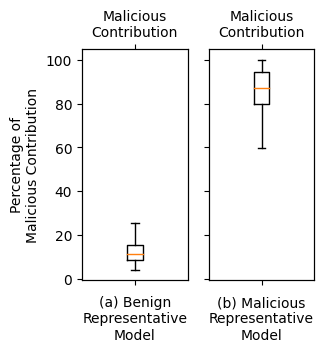

In [153]:
fig, ax = plt.subplots(figsize=(3, 3), nrows=1, ncols=2, sharey=True)

ax[0].boxplot(adv_contribs[0], showfliers=False)
ax[0].set_xticklabels([])
ax0_2 = ax[0].twiny()
ax0_2.set_xticks([0.5])
ax0_2.set_xticklabels(['Malicious\nContribution'])
ax[0].set_xlabel('(a) Benign\nRepresentative\nModel')
ax[1].boxplot(adv_contribs[1], showfliers=False)
ax[1].set_xticklabels([])
ax1_2 = ax[1].twiny()
ax1_2.set_xticks([0.5])
ax1_2.set_xticklabels(['Malicious\nContribution'])
ax[1].set_xlabel('(b) Malicious\nRepresentative\nModel')
ax[0].set_ylabel('Percentage of\nMalicious Contribution')
plt.savefig('../FLORIDA_figures/ablation_similarity_report_2.pdf', bbox_inches='tight')

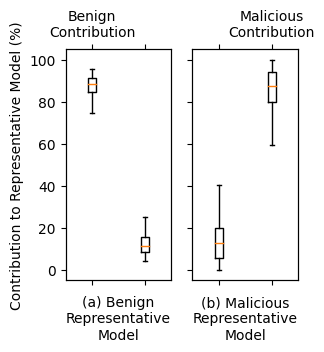

In [177]:
fig, ax = plt.subplots(figsize=(3, 3), nrows=1, ncols=2, sharey=True)

ax[0].boxplot([benign_contribs[0], adv_contribs[0]], showfliers=False)
ax[1].boxplot([benign_contribs[1], adv_contribs[1]], showfliers=False)
ax[0].set_xticklabels([])
ax0_2 = ax[0].twiny()
ax0_2.set_xticks([0.25, 0.75])
ax0_2.set_xticklabels(['Benign\nContribution', ''])
ax[0].set_xlabel('(a) Benign\nRepresentative\nModel')
ax[1].set_xticklabels([])
ax1_2 = ax[1].twiny()
ax1_2.set_xticks([0.25, 0.75])
ax1_2.set_xticklabels(['', 'Malicious\nContribution'])
ax[1].set_xlabel('(b) Malicious\nRepresentative\nModel')
ax[0].set_ylabel('Contribution to Representative Model (%)')
plt.savefig('../FLORIDA_figures/ablation_contribution_report.pdf', bbox_inches='tight')